In [ ]:
# Install/update portalocker
!pip install -U portalocker

# Download English and French spaCy models
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

2023-12-12 17:53:10.569036: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 17:53:10.569085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 17:53:10.569122: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 17:53:10.576675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 17:53:11.640235: W tensorflow/c

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'fr'

token_transform = {}
vocab_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

csv = pd.read_csv("/content/eng_-french.csv",
    usecols=['English words/sentences', 'French words/sentences']
)
csv.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


# New Section

# New Section

In [ ]:
train_csv, test_csv = train_test_split(csv, test_size=0.1)

In [ ]:
# Custom Dataset class.
class TranslationDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return(
            self.csv['English words/sentences'].iloc[idx],
            self.csv['French words/sentences'].iloc[idx]
        )

In [ ]:
train_dataset = TranslationDataset(train_csv)
valid_dataset = TranslationDataset(test_csv)
iterator = iter(train_dataset)
print(next(iterator))

('They kept him waiting outside for a long time.', 'Ils le firent poireauter dehors.')


In [ ]:
# Helper function to yield list of tokens.
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])
# Define special symbols and indices.
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab.
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Create torchtext's Vocab object.
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )
# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func
# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))
# `src` and `tgt` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor
# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

In [ ]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 192
NHEAD = 6
FFN_HID_DIM = 192
BATCH_SIZE = 192
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = 'cuda'
NUM_EPOCHS = 50

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)
    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM
).to(DEVICE)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
print(model)

14,487,719 total parameters.
14,487,719 training parameters.
Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=192, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Tr

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def train_epoch(model, optimizer):
    print('Training')
    model.train()
    losses = 0
    for src, tgt in tqdm(train_dataloader, total=len(list(train_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )
        optimizer.zero_grad()
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        losses += loss.item()
    return losses / len(list(train_dataloader))

val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def evaluate(model):
    print('Validating')
    model.eval()
    losses = 0
    for src, tgt in tqdm(val_dataloader, total=len(list(val_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        losses += loss.item()
    return losses / len(list(val_dataloader))


In [ ]:
train_loss_list, valid_loss_list = [], []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    valid_loss = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s \n"))


Training


  0%|          | 0/824 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 1, Train loss: 5.369, Val loss: 4.185, Epoch time = 172.144s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 2, Train loss: 3.946, Val loss: 3.538, Epoch time = 167.866s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 3, Train loss: 3.480, Val loss: 3.179, Epoch time = 167.352s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 4, Train loss: 3.178, Val loss: 2.925, Epoch time = 167.423s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 5, Train loss: 2.953, Val loss: 2.729, Epoch time = 167.207s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.773, Val loss: 2.567, Epoch time = 166.951s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.621, Val loss: 2.431, Epoch time = 168.599s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 8, Train loss: 2.491, Val loss: 2.315, Epoch time = 167.984s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 9, Train loss: 2.379, Val loss: 2.216, Epoch time = 168.505s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 10, Train loss: 2.282, Val loss: 2.130, Epoch time = 169.960s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 11, Train loss: 2.194, Val loss: 2.056, Epoch time = 168.340s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 12, Train loss: 2.118, Val loss: 1.990, Epoch time = 169.460s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 13, Train loss: 2.049, Val loss: 1.934, Epoch time = 167.800s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 14, Train loss: 1.986, Val loss: 1.882, Epoch time = 165.461s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 15, Train loss: 1.928, Val loss: 1.839, Epoch time = 166.824s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 16, Train loss: 1.878, Val loss: 1.796, Epoch time = 167.002s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 17, Train loss: 1.830, Val loss: 1.760, Epoch time = 170.340s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 18, Train loss: 1.786, Val loss: 1.730, Epoch time = 166.586s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 19, Train loss: 1.745, Val loss: 1.697, Epoch time = 167.321s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 20, Train loss: 1.709, Val loss: 1.672, Epoch time = 166.863s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 21, Train loss: 1.674, Val loss: 1.646, Epoch time = 167.069s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 22, Train loss: 1.643, Val loss: 1.623, Epoch time = 167.449s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 23, Train loss: 1.613, Val loss: 1.603, Epoch time = 165.506s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 24, Train loss: 1.586, Val loss: 1.585, Epoch time = 166.297s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 25, Train loss: 1.559, Val loss: 1.567, Epoch time = 165.334s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 26, Train loss: 1.534, Val loss: 1.551, Epoch time = 167.498s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 27, Train loss: 1.511, Val loss: 1.536, Epoch time = 165.978s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 28, Train loss: 1.489, Val loss: 1.524, Epoch time = 165.563s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 29, Train loss: 1.467, Val loss: 1.509, Epoch time = 165.189s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 30, Train loss: 1.449, Val loss: 1.495, Epoch time = 165.645s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 31, Train loss: 1.430, Val loss: 1.485, Epoch time = 164.668s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 32, Train loss: 1.411, Val loss: 1.474, Epoch time = 165.790s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 33, Train loss: 1.395, Val loss: 1.461, Epoch time = 164.558s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 34, Train loss: 1.379, Val loss: 1.454, Epoch time = 166.602s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 35, Train loss: 1.363, Val loss: 1.444, Epoch time = 165.382s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 36, Train loss: 1.350, Val loss: 1.437, Epoch time = 165.770s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 37, Train loss: 1.335, Val loss: 1.425, Epoch time = 164.845s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 38, Train loss: 1.321, Val loss: 1.417, Epoch time = 166.014s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 39, Train loss: 1.308, Val loss: 1.409, Epoch time = 165.289s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 40, Train loss: 1.295, Val loss: 1.404, Epoch time = 166.050s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 41, Train loss: 1.284, Val loss: 1.396, Epoch time = 165.682s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 42, Train loss: 1.272, Val loss: 1.389, Epoch time = 165.757s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 43, Train loss: 1.262, Val loss: 1.384, Epoch time = 165.443s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 44, Train loss: 1.250, Val loss: 1.378, Epoch time = 165.851s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 45, Train loss: 1.238, Val loss: 1.373, Epoch time = 169.344s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 46, Train loss: 1.229, Val loss: 1.368, Epoch time = 169.602s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 47, Train loss: 1.220, Val loss: 1.362, Epoch time = 167.566s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 48, Train loss: 1.209, Val loss: 1.360, Epoch time = 165.857s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 49, Train loss: 1.202, Val loss: 1.354, Epoch time = 164.278s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 50, Train loss: 1.193, Val loss: 1.349, Epoch time = 166.285s 



In [ ]:
os.makedirs('outputs', exist_ok=True)

In [ ]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss plots to disk.
    """
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', 'loss.png'))
    plt.show()

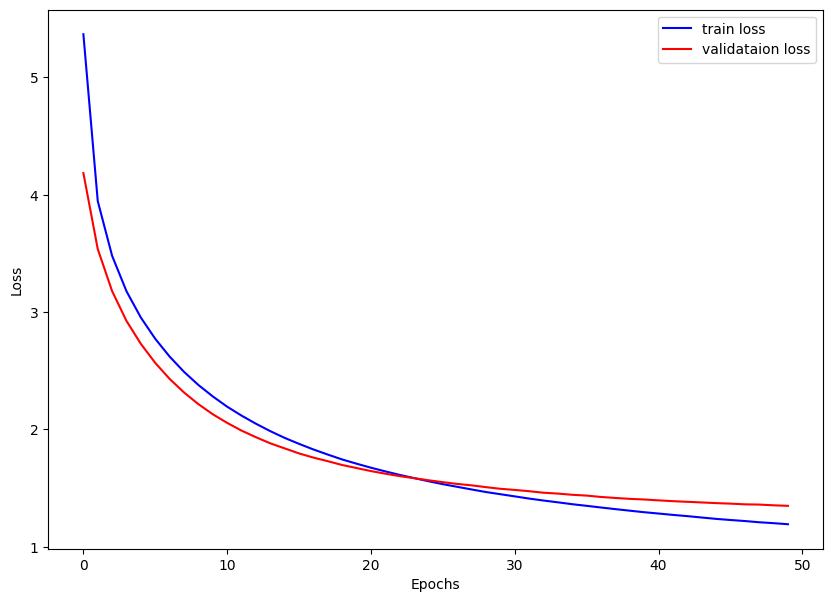

In [ ]:
save_plots(train_loss_list, valid_loss_list)

In [ ]:
torch.save(model, 'outputs/model.pth')

In [ ]:
model = torch.load('outputs/model.pth')

In [ ]:
# Helper function to generate output sequence using greedy algorithm.
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if i == 0:
            ys = ys.transpose(1, 0)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys
# Translation function.
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


In [ ]:
# SRC, GT pairs from the validation set.
infer_sentences = [
    ["Take a seat.", "Prends place !"],
    ["I'm not scared to die", "Je ne crains pas de mourir."],
    ["You'd better make sure that it is true.", "Tu ferais bien de t'assurer que c'est vrai."],
    ["The clock has stopped.", "L'horloge s'est arrêtée."],
    ["Take any two cards you like.", "Prends deux cartes de ton choix."]
]
for sentence in infer_sentences:
    print(f"SRC: {sentence[0]}")
    print(f"GT: {sentence[1]}")
    print(f"PRED: {translate(model, sentence[0])}\n")

SRC: Take a seat.
GT: Prends place !
PRED:  Prends une place ! 

SRC: I'm not scared to die
GT: Je ne crains pas de mourir.
PRED:  Je ne suis pas effrayé de mourir . 

SRC: You'd better make sure that it is true.
GT: Tu ferais bien de t'assurer que c'est vrai.
PRED:  Tu ferais mieux de t' assurer que c' est vrai . 

SRC: The clock has stopped.
GT: L'horloge s'est arrêtée.
PRED:  La horloge s' est arrêtée . 

SRC: Take any two cards you like.
GT: Prends deux cartes de ton choix.
PRED:  Prenez deux cartes de ce que vous aimez . 



In [ ]:
a1 = "I am a good girl"

In [ ]:
print(translate(model, a1))

 Je suis une bonne fille . 


In [ ]:
a1 = "Today is my presentation"

In [ ]:
print(translate(model, a1))

 Aujourd'hui est mon sujet . 
